In [ ]:
import torch
print(torch.__version__)

2.5.1+cu121


In [ ]:
!python --version

Python 3.10.12


In [ ]:
!rm -rf /content/bert_imb

# <font color = 'indianred'>**Multilabel Classification of StackExchange Dataset using GEMMA** </font>

**Objective:**

In this notebook, we aim to use GEMMA models with QLORA for classification problems. **We will now use Casual Languagge Model - Basically we will do instruction tuning.**


**Plan**

1. Set Environment
2. Load Dataset
3. Accessing and Manipulating Splits
4. Load Pre-trained Tokenizer
5. Create Prompts
6. Model Training
  1. Download pre-trained model <br>  
  3. PEFT Setup
  4. Training Arguments <br>
  5. Instantiate Trainer <br>
  6. Setup WandB <br>
  7. Training
  8. Validation
7. Perfromance on Test Set
8. Model Inference






















# <font color = 'indianred'> **1. Setting up the Environment** </font>



In [ ]:
# If in Colab, then import the drive module from google.colab
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  # Mount the Google Drive to access files stored there
  drive.mount('/content/drive')

  # Install the latest version of torchtext library quietly without showing output
  # !pip install torchtext -qq
  !pip install transformers evaluate wandb datasets accelerate peft bitsandbytes trl -U  -qq ## NEW LINES ##
  basepath = '/content/drive/MyDrive/data/'
else:
  basepath = '/home/harpreet/Insync/google_drive_shaannorr/data'

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 93.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 36.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 MB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.9/310.9 kB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 wh

<font color = 'indianred'> *Load Libraries* </font>

In [ ]:
# standard data science librraies for data handling and v isualization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import re
import gc
import time

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix, precision_score, recall_score, f1_score
import joblib

import torch
import torch.nn as nn
import ast


# New libraries introduced in this notebook
import evaluate
from datasets import load_dataset, DatasetDict, Dataset, ClassLabel
from trl import SFTConfig, SFTTrainer, DataCollatorForCompletionOnlyLM
from transformers import (
    TrainingArguments,
    Trainer,
    set_seed,
    AutoTokenizer,
    AutoModelForCausalLM,
    DataCollatorForLanguageModeling,
    AutoConfig,
    pipeline,
    BitsAndBytesConfig,
)
from peft import (
    TaskType,
    LoraConfig,
    prepare_model_for_kbit_training,
    get_peft_model,
)

import wandb
from google.colab import userdata
from huggingface_hub import login


In [ ]:
set_seed(42)

In [ ]:
wandb_api_key = userdata.get('WANDB_API_KEY')
hf_token = userdata.get('HF_TOKEN')


In [ ]:
if hf_token:
    # Log in to Hugging Face
    login(token=hf_token)
    print("Successfully logged in to Hugging Face!")
else:
    print("Hugging Face token not found in notebook secrets.")


Successfully logged in to Hugging Face!


In [ ]:
if wandb_api_key:
  wandb.login(key=wandb_api_key)
  print("Successfully logged in to WANDB!")
else:
    print("WANDB key not found in notebook secrets.")


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Successfully logged in to WANDB!


In [ ]:
# CHANGE FOLDERS TO WHERE YOU WANT TO SAVE DATA AND MODELS
base_folder = Path(basepath)
data_folder = base_folder/'datasets/Classification_HW/joblib_files'

# <font color = 'indianred'> **2. Load Data set**
    


In [ ]:
df = joblib.load(data_folder/'df_multilabel_hw_cleaned.joblib')
df

,cleaned_text,Tags,Tag_Number
0,asp query stre dropdown webpage follow control...,c# asp.net,"[0, 9]"
1,run javascript code server java code want run ...,java javascript,"[1, 3]"
2,linq sql throw exception row find change hi li...,c# asp.net,"[0, 9]"
3,run python script php server run nginx web ser...,php python,"[2, 7]"
4,advice write function m try write function res...,javascript jquery,"[3, 5]"
...,...,...,...
47422,take value edittext put decimal point all- wor...,java android,"[1, 4]"
47423,listen phone state application nee liste phone...,java android,"[1, 4]"
47424,android ui thread thread task want access main...,java android,"[1, 4]"
47425,dynamic table row creation html javascript htm...,asp.net javascript,"[9, 3]"


In [ ]:
stack_dataset = Dataset.from_pandas(df)

In [ ]:
selected_columns = {
    'text': stack_dataset['cleaned_text'],
    'tag': stack_dataset['Tags']
}

# Create a new dataset with the selected columns
stack_selected_columns = Dataset.from_dict(selected_columns)

In [ ]:
stack_selected_columns

Dataset({
    features: ['text', 'tag'],
    num_rows: 47427
})

In [ ]:
stack_selected_columns['tag'][0]

'c# asp.net'

In [ ]:
# Set the format to Pandas
stack_selected_columns.set_format(type='pandas')

In [ ]:
df = stack_selected_columns[:]

In [ ]:
# Remove existing quotes first (if any) and then add just one set
import json
df['label'] = df['tag'].str.split().apply(lambda x: json.dumps([tag.strip() for tag in x]))


In [ ]:
df

,text,tag,label
0,asp query stre dropdown webpage follow control...,c# asp.net,"[""c#"", ""asp.net""]"
1,run javascript code server java code want run ...,java javascript,"[""java"", ""javascript""]"
2,linq sql throw exception row find change hi li...,c# asp.net,"[""c#"", ""asp.net""]"
3,run python script php server run nginx web ser...,php python,"[""php"", ""python""]"
4,advice write function m try write function res...,javascript jquery,"[""javascript"", ""jquery""]"
...,...,...,...
47422,take value edittext put decimal point all- wor...,java android,"[""java"", ""android""]"
47423,listen phone state application nee liste phone...,java android,"[""java"", ""android""]"
47424,android ui thread thread task want access main...,java android,"[""java"", ""android""]"
47425,dynamic table row creation html javascript htm...,asp.net javascript,"[""asp.net"", ""javascript""]"


In [ ]:
df_final = df[['text', 'label']]

In [ ]:
df_final

,text,label
0,asp query stre dropdown webpage follow control...,"[""c#"", ""asp.net""]"
1,run javascript code server java code want run ...,"[""java"", ""javascript""]"
2,linq sql throw exception row find change hi li...,"[""c#"", ""asp.net""]"
3,run python script php server run nginx web ser...,"[""php"", ""python""]"
4,advice write function m try write function res...,"[""javascript"", ""jquery""]"
...,...,...
47422,take value edittext put decimal point all- wor...,"[""java"", ""android""]"
47423,listen phone state application nee liste phone...,"[""java"", ""android""]"
47424,android ui thread thread task want access main...,"[""java"", ""android""]"
47425,dynamic table row creation html javascript htm...,"[""asp.net"", ""javascript""]"


In [ ]:
class_names = ['c#', 'java', 'php','javascript', 'android', 'jquery', 'c++',  'python', 'iphone', 'asp.net']

In [ ]:
stack_selected_columns_final = Dataset.from_pandas(df_final)

In [ ]:
stack_selected_columns_final[0]['label']

'["c#", "asp.net"]'

# <font color = 'indianred'> **3. Accessing and Manuplating Splits**</font>



<font color = 'indianred'>*Create futher subdivions of the splits*</font>

In [ ]:
# Split the test set into test and validation sets
test_val_splits = stack_selected_columns_final.train_test_split(test_size=0.4, seed=42)
train_split= test_val_splits['train']
test_val_splits = test_val_splits['test'].train_test_split(test_size=0.5, seed=42,)
val_split = test_val_splits['train']
test_split = test_val_splits['test']


<font color = 'indianred'>*small subset for initial experimenttaion*</font>

In [ ]:
train_split = train_split.shuffle(seed = 42).select(range(2000))
val_split = val_split.shuffle(seed = 42).select(range(2000))
test_split = test_split.shuffle(seed = 42).select(range(2000))

In [ ]:
train_val_subset= DatasetDict(
    {"train": train_split, "valid": val_split})

In [ ]:
train_val_subset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    valid: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [ ]:
train_val_subset['train'][0]

{'text': 'edit link place use javascript edit text place need edit link click link instead make editable redirect link address change double click link editable redirect help',
 'label': '["javascript", "jquery"]'}

# <font color = 'indianred'>**4. Load pre-trained Tokenizer**</font>



In [ ]:
def free_gpu_memory():
    """
    Frees up GPU memory after CUDA out-of-memory error in Colab.

    This function performs the following steps:
    1. Deletes all PyTorch objects to clear references.
    2. Calls garbage collection to remove unreferenced objects from memory.
    3. Uses torch.cuda.empty_cache() to release cached GPU memory.
    4. Waits for a moment to ensure memory is fully released.
    """
    try:
        # Delete all torch tensors to free up memory
        for obj in list(locals().values()):
            if torch.is_tensor(obj):
                del obj

        # Collect garbage to release any remaining unused memory
        gc.collect()

        # Empty the CUDA cache to release GPU memory
        torch.cuda.empty_cache()

        # Adding a small delay to allow memory to be fully released
        time.sleep(2)

        print("GPU memory has been freed.")
    except Exception as e:
        print(f"Error while freeing GPU memory: {e}")


In [ ]:
free_gpu_memory()

GPU memory has been freed.


In [ ]:
checkpoint = "google/gemma-2-2b-it"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [ ]:
tokenizer.eos_token

'<eos>'

In [ ]:
tokenizer.pad_token

'<pad>'

#<font color = 'indianred'> **5. Create Prompts**



In [ ]:
class_names

['c#',
 'java',
 'php',
 'javascript',
 'android',
 'jquery',
 'c++',
 'python',
 'iphone',
 'asp.net']

In [ ]:
def format_chat(example):
    instruction = f"Classify the TEXT by selecting all applicable labels from the following list: {class_names}.\n\nTEXT: {example['text']}"
    messages = [
        {"role": "user", "content": instruction},
        {"role": "assistant", "content": ""}
    ]
    return {"text": tokenizer.apply_chat_template(messages, tokenize=False)}


In [ ]:
train_val_subset_chat = train_val_subset.map(format_chat)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
train_val_subset_chat

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    valid: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [ ]:
train_val_subset_chat['train'][0]

{'text': "<bos><start_of_turn>user\nClassify the TEXT by selecting all applicable labels from the following list: ['c#', 'java', 'php', 'javascript', 'android', 'jquery', 'c++', 'python', 'iphone', 'asp.net'].\n\nTEXT: edit link place use javascript edit text place need edit link click link instead make editable redirect link address change double click link editable redirect help<end_of_turn>\n<start_of_turn>model\njavascript, jquery<end_of_turn>\n",
 'label': '["javascript", "jquery"]'}

##  <font color = 'indianred'> **5.1 Filter Longer sequences**

In [ ]:
def check_length(example):
   encoding = tokenizer.encode(example['text'])
   return len(encoding) <= 1000

train_filtered = train_val_subset_chat['train'].filter(check_length)
valid_filtered = train_val_subset_chat['valid'].filter(check_length)

print(f"Train: {len(train_val_subset_chat['train'])} -> {len(train_filtered)}")
print(f"Valid: {len(train_val_subset_chat['valid'])} -> {len(valid_filtered)}")

Filter:   0%|          | 0/2000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2000 [00:00<?, ? examples/s]

Train: 2000 -> 1953
Valid: 2000 -> 1959


#  <font color = 'indianred'> **6. Model Training**

##  <font color = 'indianred'> **6.1 Download pre-trained model**

In [ ]:
def get_appropriate_dtype():
    if torch.cuda.is_available() and torch.cuda.get_device_capability(0) >= (8, 0):
        return torch.bfloat16
    return torch.float16

In [ ]:
torch_data_type = get_appropriate_dtype()
torch_data_type

torch.bfloat16

In [ ]:
bnb_config = BitsAndBytesConfig(
  load_in_4bit=True,
  bnb_4bit_quant_type="nf4",
  bnb_4bit_use_double_quant=True,
  bnb_4bit_compute_dtype=torch_data_type,
  bnb_4bit_quant_storage=torch_data_type,
)

In [ ]:
model = AutoModelForCausalLM.from_pretrained(checkpoint,
                                             quantization_config=bnb_config,
                                             torch_dtype=torch_data_type,
                                             trust_remote_code=True,)


config.json:   0%|          | 0.00/838 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now default to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/24.2k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/241M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

##  <font color = 'indianred'> **6.2 PEFT Setup**

In [ ]:
model

Gemma2ForCausalLM(
  (model): Gemma2Model(
    (embed_tokens): Embedding(256000, 2304, padding_idx=0)
    (layers): ModuleList(
      (0-25): 26 x Gemma2DecoderLayer(
        (self_attn): Gemma2Attention(
          (q_proj): Linear4bit(in_features=2304, out_features=2048, bias=False)
          (k_proj): Linear4bit(in_features=2304, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=2304, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=2048, out_features=2304, bias=False)
          (rotary_emb): Gemma2RotaryEmbedding()
        )
        (mlp): Gemma2MLP(
          (gate_proj): Linear4bit(in_features=2304, out_features=9216, bias=False)
          (up_proj): Linear4bit(in_features=2304, out_features=9216, bias=False)
          (down_proj): Linear4bit(in_features=9216, out_features=2304, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): Gemma2RMSNorm((2304,), eps=1e-06)
        (pre_feedforward_layernorm)

In [ ]:
def find_linear_layers(model):
    """
    Extracts the unique names of Linear layers from a model.

    Args:
    model (nn.Module): The model from which to extract Linear layer names.

    Returns:
    list: A list of unique names of Linear layers.
    """
    # Convert the model's modules to string
    model_modules = str(model.modules)
    # Pattern to extract names of Linear layers
    pattern = r'\((\w+)\): Linear'
    # Find all occurrences of the pattern
    linear_layer_names = re.findall(pattern, model_modules)
    print(linear_layer_names)
    # Get unique names using a set, then convert back to list
    target_modules = list(set(linear_layer_names))
    return target_modules

In [ ]:
find_linear_layers(model)

['q_proj', 'k_proj', 'v_proj', 'o_proj', 'gate_proj', 'up_proj', 'down_proj', 'lm_head']


['gate_proj',
 'down_proj',
 'q_proj',
 'k_proj',
 'v_proj',
 'up_proj',
 'lm_head',
 'o_proj']

In [ ]:
TaskType.CAUSAL_LM

<TaskType.CAUSAL_LM: 'CAUSAL_LM'>

In [ ]:
peft_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    r=128,
    lora_alpha=256,
    lora_dropout=0.01,
    target_modules = ['v_proj',  'q_proj',  'up_proj', 'o_proj', 'down_proj', 'gate_proj','k_proj'])

lora_model = get_peft_model(model, peft_config )
# qlora_model.resize_token_embeddings(len(tokenizer))
lora_model.print_trainable_parameters()

trainable params: 166,133,760 || all params: 2,780,475,648 || trainable%: 5.9750


## <font color = 'indianred'> **6.3 Training Arguments**</font>







In [ ]:
# Define the directory where model checkpoints will be saved
model_folder = base_folder/'models/gemma_qlora_lmh_inst'

# Create the directory if it doesn't exist
model_folder.mkdir(exist_ok=True, parents=True)
run_name= 'stack_exp_lmh_gemma_inst'

use_fp16 = torch_data_type == torch.float16
use_bf16 = torch_data_type == torch.bfloat16

# Configure training parameters
training_args = SFTConfig(
    seed = 42,
    # Training-specific configurations
    num_train_epochs=2,  # Total number of training epochs
    # Number of samples per training batch for each device
    per_device_train_batch_size=4,
    # Number of samples per evaluation batch for each device
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=8,
    gradient_checkpointing=True,
    gradient_checkpointing_kwargs={"use_reentrant":False},
    # torch_empty_cache_steps=5,
    weight_decay=0.0,  # Apply L2 regularization to prevent overfitting
    learning_rate=1e-5,  # Step size for the optimizer during training
    optim='adamw_torch',  # Optimizer,

    # Checkpoint saving and model evaluation settings
    output_dir=str(model_folder),  # Directory to save model checkpoints
    eval_strategy='steps',  # Evaluate model at specified step intervals
    eval_steps=20,  # Perform evaluation every 10 training steps
    save_strategy="steps",  # Save model checkpoint at specified step intervals
    save_steps=20,  # Save a model checkpoint every 10 training steps
    load_best_model_at_end=True,  # Reload the best model at the end of training
    save_total_limit=2,  # Retain only the best and the most recent model checkpoints
    # Use 'accuracy' as the metric to determine the best model
    metric_for_best_model="eval_loss",
    greater_is_better=False,  # A model is 'better' if its accuracy is higher


    # Experiment logging configurations (commented out in this example)
    logging_strategy='steps',
    logging_steps=20,
    report_to='wandb',  # Log metrics and results to Weights & Biases platform
    run_name= run_name,  # Experiment name for Weights & Biases

    # Precision settings determined based on GPU capability
    fp16=use_fp16 ,  # Set True if torch_data_type is torch.float16
    bf16=use_bf16,  # Set True if torch_data_type is torch.bfloat16
    tf32=False,  # Disable tf32 unless you want to use Ampere specific optimization
)


In [ ]:
# If gradient checkpointing is enabled, configure relevant settings
if training_args.gradient_checkpointing:
    model.config.use_cache = False  # Disable caching for compatibility

model.config

Gemma2Config {
  "_attn_implementation_autoset": true,
  "_name_or_path": "google/gemma-2-2b-it",
  "architectures": [
    "Gemma2ForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "attn_logit_softcapping": 50.0,
  "bos_token_id": 2,
  "cache_implementation": "hybrid",
  "eos_token_id": [
    1,
    107
  ],
  "final_logit_softcapping": 30.0,
  "head_dim": 256,
  "hidden_act": "gelu_pytorch_tanh",
  "hidden_activation": "gelu_pytorch_tanh",
  "hidden_size": 2304,
  "initializer_range": 0.02,
  "intermediate_size": 9216,
  "max_position_embeddings": 8192,
  "model_type": "gemma2",
  "num_attention_heads": 8,
  "num_hidden_layers": 26,
  "num_key_value_heads": 4,
  "pad_token_id": 0,
  "quantization_config": {
    "_load_in_4bit": true,
    "_load_in_8bit": false,
    "bnb_4bit_compute_dtype": "bfloat16",
    "bnb_4bit_quant_storage": "bfloat16",
    "bnb_4bit_quant_type": "nf4",
    "bnb_4bit_use_double_quant": true,
    "llm_int8_enable_fp32_cpu_offload": false,

##  <font color = 'indianred'> **6.4 Initialize Trainer**</font>



In [ ]:
data_collator_comp = DataCollatorForCompletionOnlyLM(tokenizer=tokenizer, mlm=False,
                                                      response_template="<start_of_turn>model\n")
trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=train_filtered,
    eval_dataset=valid_filtered,
    dataset_text_field="text",
    peft_config=peft_config,
    packing=False,
    data_collator=data_collator_comp
)

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:328: UserWarning: You passed a `dataset_text_field` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/1953 [00:00<?, ? examples/s]

Map:   0%|          | 0/1959 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:403: UserWarning: You passed a processing_class with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due to overflow issues when training a model in half-precision. You might consider adding `processing_class.padding_side = 'right'` to your code.
  warnings.warn(


## <font color = 'indianred'> **6.5 Setup WandB**</font>

In [ ]:
%env WANDB_PROJECT = multilabel_stack

env: WANDB_PROJECT=multilabel_stack


##  <font color = 'indianred'> **6.7 Training**

In [ ]:
try:
    # Your code that may cause a CUDA out-of-memory error
    # Example: trainer.train() or other GPU intensive operations
    # lora_model.config.use_cache = False
    trainer.train()
except RuntimeError as e:
    if 'CUDA out of memory' in str(e):
        print("CUDA out of memory error detected. Freeing GPU memory.")
        free_gpu_memory()
        # Optionally, you can retry the operation here after freeing up memory
        # Example retry:
        # trainer.train()
    else:
        raise e


wandb: Currently logged in as: hsingh-utd. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss
20,0.973600,0.198797
40,0.195700,0.158946
60,0.149400,0.139537
80,0.100600,0.139890
100,0.122800,0.134926
120,0.106200,0.128514


In [ ]:
best_model_checkpoint_step = trainer.state.best_model_checkpoint.split('-')[-1]

In [ ]:
best_model_checkpoint_step

'120'

##  <font color = 'indianred'> **6.8 Validation**

<font color = 'indianred'> *Evaluate model on Validation Set* </font>


In [ ]:
def format_chat_inference(example):
    instruction = f"Classify the TEXT by selecting all applicable labels from the following list: {class_names}.\n\nTEXT: {example['text']}"
    messages = [
        {"role": "user", "content": instruction},
        {"role": "assistant", "content": ""}
    ]
    text = tokenizer.apply_chat_template(messages, tokenize=False)
    # Remove the final <end_of_turn>
    if text.endswith("<end_of_turn>\n"):
        text = text[:-len("<end_of_turn>\n")]
    return {"text": text}

In [ ]:
valid_subset= train_val_subset['valid'].map(format_chat_inference)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
valid_filtered = valid_subset.filter(check_length)

Filter:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
valid_filtered['text'][0]

'<bos><start_of_turn>user\nClassify the TEXT by selecting all applicable labels from the following list: [\'c#\', \'java\', \'php\', \'javascript\', \'android\', \'jquery\', \'c++\', \'python\', \'iphone\', \'asp.net\'].\n\nTEXT: seperate jquery script selector external file work jquery selector event associate want external file copy directly save thing external javascript selector work explain note able use function html file externalize work script follows:-   $ pervious\').click(function          var presentslide = $ .visible\').attr(\'id          var temparr = presentslide.split("-          var persentslideno = temparr[1          var perviousslideno = number(persentslideno 1 perviousslideno > -1                    var perviousslide = slide- + perviousslideno               $ + presentslide).fadeout(\'slow\',function              $ this).removeclass(\'visible\').addclass(\'hidden                           $ + perviousslide).fadein(\'slow\',function              $ this).removeclass(\

In [ ]:
model_folder = base_folder/'models/gemma_qlora_lmh_inst'
best_model_checkpoint_step
checkpoint = str(model_folder/f'checkpoint-{best_model_checkpoint_step}')
checkpoint

'/content/drive/MyDrive/data/models/gemma_qlora_lmh_inst/checkpoint-120'

In [ ]:
from peft import AutoPeftModelForCausalLM, PeftConfig

In [ ]:
model = AutoPeftModelForCausalLM.from_pretrained(checkpoint,
                                             quantization_config=bnb_config,
                                             torch_dtype=torch_data_type,
                                             trust_remote_code=True,
                                             device_map='auto')

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
model.device

device(type='cuda', index=0)

In [ ]:
peft_config = PeftConfig.from_pretrained(checkpoint)
base_model_name = peft_config.base_model_name_or_path
tokenizer = AutoTokenizer.from_pretrained(base_model_name)

In [ ]:
response_template = "<start_of_turn>model\n"

In [ ]:
def extract_content_fixed(text, response_template="<start_of_turn>model\n"):
    # Find content between model start and end tokens or eos
    pattern = f'{response_template}(.*?)(?:<end_of_turn>|<eos>)'
    match = re.search(pattern, text, re.DOTALL)
    if match:
        content = match.group(1).strip()
        return content
    return None

def run_inference_instruction(seed, dataset, model, tokenizer, per_device_batch_size,
                           max_new_tokens=10, num_beams=1, do_sample=False,
                           top_k=50, top_p=1, temperature=1.0):
   set_seed(seed)
   model.eval()
   device = model.device
   batch_size = per_device_batch_size
   responses = []
   extracted_outputs = []

   dataset_list = list(dataset)

   progress_bar = tqdm(range(0, len(dataset_list), batch_size), desc="Generating predictions")

   for i in progress_bar:
       batch = dataset_list[i:i + batch_size]

       try:
           inputs = tokenizer([ex['text'] for ex in batch], return_tensors="pt", padding=True)
           inputs = {k: v.to(device) for k, v in inputs.items()}

           with torch.no_grad():
               outputs = model.generate(
                   **inputs,
                   max_new_tokens=max_new_tokens,
                   num_beams=num_beams,
                   do_sample=do_sample,
                   top_k=top_k,
                   top_p=top_p,
                   temperature=temperature,
                   pad_token_id=tokenizer.pad_token_id,
               )

           decoded_outputs = tokenizer.batch_decode(outputs, skip_special_tokens=False)

           for item, decoded_output in zip(batch, decoded_outputs):
               extracted_output = extract_content_fixed(decoded_output)
               responses.append({
                   "input": item['text'],
                   "generated_output": decoded_output,
                   "true_output": item['label']
               })
               extracted_outputs.append({
                   "input": item['text'],
                   "extracted_output": extracted_output,
                   "true_output": item['label']
               })

       except Exception as e:
           print(f"Error processing batch: {str(e)}")
           continue

   return responses, extracted_outputs

In [ ]:
free_gpu_memory()

GPU memory has been freed.


In [ ]:
# Run inference
valid_responses, valid_extracted_outputs = run_inference_instruction(
    seed=42,
    dataset=valid_filtered,
    model=model,
    tokenizer=tokenizer,
    per_device_batch_size=30,
)

Generating predictions: 100%|██████████| 66/66 [02:44<00:00,  2.49s/it]


In [ ]:
# Print a few examples
for i in range(min(3, len(valid_extracted_outputs))):
    print(f"\nExample {i+1}:")
    print(f"Input: {valid_extracted_outputs[i]['input']}")
    print(f"Predicted: {valid_extracted_outputs[i]['extracted_output']}")
    print(f"True: {valid_extracted_outputs[i]['true_output']}")


Example 1:
Input: <bos><start_of_turn>user
Classify the TEXT by selecting all applicable labels from the following list: ['c#', 'java', 'php', 'javascript', 'android', 'jquery', 'c++', 'python', 'iphone', 'asp.net'].

TEXT: seperate jquery script selector external file work jquery selector event associate want external file copy directly save thing external javascript selector work explain note able use function html file externalize work script follows:-   $ pervious').click(function          var presentslide = $ .visible').attr('id          var temparr = presentslide.split("-          var persentslideno = temparr[1          var perviousslideno = number(persentslideno 1 perviousslideno > -1                    var perviousslide = slide- + perviousslideno               $ + presentslide).fadeout('slow',function              $ this).removeclass('visible').addclass('hidden                           $ + perviousslide).fadein('slow',function              $ this).removeclass('hidden').addcla

In [ ]:
for i in range(10):
  print(valid_extracted_outputs[i]['extracted_output'])

javascript, jquery
javascript, jquery
java, android
java, android
javascript, asp.net
javascript, jquery
javascript, jquery
c#, asp.net
java, android
javascript, jquery


In [ ]:
from difflib import get_close_matches

def clean_and_split_labels(label_set, class_names, cutoff=0.6):
    if isinstance(label_set, (list, tuple)):
        label_set = ' '.join(str(x) for x in label_set)

    # Handle JSON string format
    label_set = str(label_set).replace('["', '').replace('"]', '')

    # Split by comma since that's the format we're getting
    raw_labels = [label.strip() for label in label_set.split(',')]

    cleaned_labels = []
    for label in raw_labels:
        label = label.lower().strip()
        if not label:
            continue

        if label in class_names:
            cleaned_labels.append(label)
            continue

        matches = get_close_matches(label, class_names, n=1, cutoff=cutoff)
        if matches:
            cleaned_labels.append(matches[0])

    return cleaned_labels

# Define your class names
class_names = ['c#', 'java', 'php', 'javascript', 'android', 'jquery', 'c++', 'python', 'iphone', 'asp.net']

# Clean the labels and predictions
valid_labels = [clean_and_split_labels(output['true_output'], class_names) for output in valid_extracted_outputs]
valid_predictions = [clean_and_split_labels(output['extracted_output'], class_names) for output in valid_extracted_outputs]

# Initialize MultiLabelBinarizer with known classes
mlb = MultiLabelBinarizer(classes=class_names)
mlb.fit(class_names)  # Fit with all possible classes

# Transform the data
valid_labels_binary = mlb.transform(valid_labels)
valid_predictions_binary = mlb.transform(valid_predictions)

# Test print
print("Sample of true labels:", valid_labels[:5])
print("Sample of predictions:", valid_predictions[:5])
print("\nBinary format:")
print("Labels shape:", valid_labels_binary.shape)
print("Predictions shape:", valid_predictions_binary.shape)

Sample of true labels: [['javascript', 'jquery'], ['javascript', 'jquery'], ['java', 'android'], ['c#', 'asp.net'], ['c#', 'javascript', 'asp.net']]
Sample of predictions: [['javascript', 'jquery'], ['javascript', 'jquery'], ['java', 'android'], ['java', 'android'], ['javascript', 'asp.net']]

Binary format:
Labels shape: (1960, 10)
Predictions shape: (1960, 10)


In [ ]:
accuracy = evaluate.load('accuracy', 'multilabel')
f1 = evaluate.load('f1','multilabel')
accuracy_flatten = evaluate.load('accuracy')
def compute_metrics( labels, preds):
  accuracy_label = accuracy_flatten.compute(predictions=preds.flatten(), references=labels.flatten())
  accuracy_all = accuracy.compute(predictions=preds, references=labels)
  f1_micro = f1.compute(predictions=preds, references=labels, average='micro')
  f1_macro = f1.compute(predictions=preds, references=labels, average='macro')
  return {'f1_micro':f1_micro['f1'],
          'f1_macro':f1_macro['f1'],
          'accuracy_label':accuracy_label['accuracy'],
            'accuracy_all':accuracy_all['accuracy']}

In [ ]:
valid_results = compute_metrics(valid_labels_binary , valid_predictions_binary)

In [ ]:
valid_results

{'f1_micro': 0.9173697270471464,
 'f1_macro': 0.845142284503892,
 'accuracy_label': 0.9660204081632653,
 'accuracy_all': 0.8198979591836735}

In [ ]:
wandb.log({"valid_f1_macro": valid_results["f1_macro"]})

<font color = 'indianred'> *Confusion Matrix*</font>

In [ ]:
mcm = multilabel_confusion_matrix(valid_labels_binary , valid_predictions_binary)
print(mcm)

[[[1460   64]
  [  61  375]]

 [[1638   10]
  [  20  292]]

 [[1721   23]
  [  47  169]]

 [[ 711   72]
  [  74 1103]]

 [[1670    2]
  [  16  272]]

 [[ 851   52]
  [  56 1001]]

 [[1921    5]
  [  12   22]]

 [[1936    0]
  [   8   16]]

 [[1945    1]
  [   8    6]]

 [[1384   51]
  [  84  441]]]


In [ ]:
def multilabel_evaluation(y_true, y_pred, class_names=None, figsize=(12, 8)):
    """
    Generate comprehensive evaluation visualizations for multilabel classification results.

    Parameters:
    -----------
    y_true : array-like
        True labels (n_samples, n_classes)
    y_pred : array-like
        Predicted labels (n_samples, n_classes)
    class_names : list, optional
        List of class names for better visualization
    figsize : tuple, optional
        Base figure size for plots (width, height)

    Returns:
    --------
    dict
        Dictionary containing the computed metrics for each class
    """
    # Validate inputs
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    if y_true.shape != y_pred.shape:
        raise ValueError("y_true and y_pred must have the same shape")

    # Generate class names if not provided
    if class_names is None:
        class_names = [f'Class {i}' for i in range(y_true.shape[1])]

    # Calculate confusion matrices
    mcm = multilabel_confusion_matrix(y_true, y_pred)

    # 1. Individual Confusion Matrix Heatmaps
    n_classes = len(class_names)
    n_cols = min(3, n_classes)
    n_rows = (n_classes + n_cols - 1) // n_cols

    plt.figure(figsize=(figsize[0], figsize[1] * n_rows/2))
    for idx, matrix in enumerate(mcm):
        plt.subplot(n_rows, n_cols, idx + 1)
        sns.heatmap(matrix, annot=True, fmt='g', cmap='Blues',
                    xticklabels=['Pred Neg', 'Pred Pos'],
                    yticklabels=['True Neg', 'True Pos'])
        plt.title(f'{class_names[idx]}')
    plt.tight_layout()
    plt.show()

    # 2. Calculate and plot aggregate metrics
    metrics = {
        'Precision': precision_score(y_true, y_pred, average=None),
        'Recall': recall_score(y_true, y_pred, average=None),
        'F1-Score': f1_score(y_true, y_pred, average=None)
    }

    metrics_df = pd.DataFrame(metrics, index=class_names)

    # Metrics Heatmap
    plt.figure(figsize=(figsize[0]/1.5, figsize[1]/1.5))
    sns.heatmap(metrics_df, annot=True, fmt='.3f', cmap='Blues')
    plt.title('Performance Metrics by Class')
    plt.tight_layout()
    plt.show()

    # 3. Metrics Histogram
    plt.figure(figsize=(figsize[0], figsize[1]/1.5))
    metrics_df.plot(kind='bar', width=0.8)
    plt.xlabel('Classes')
    plt.ylabel('Score')
    plt.title('Precision, Recall, and F1-Score by Class')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # 4. Calculate and return summary statistics
    summary_stats = {
        'macro_avg': {
            'precision': np.mean(metrics['Precision']),
            'recall': np.mean(metrics['Recall']),
            'f1': np.mean(metrics['F1-Score'])
        },
        'per_class': metrics_df.to_dict()
    }

    return summary_stats


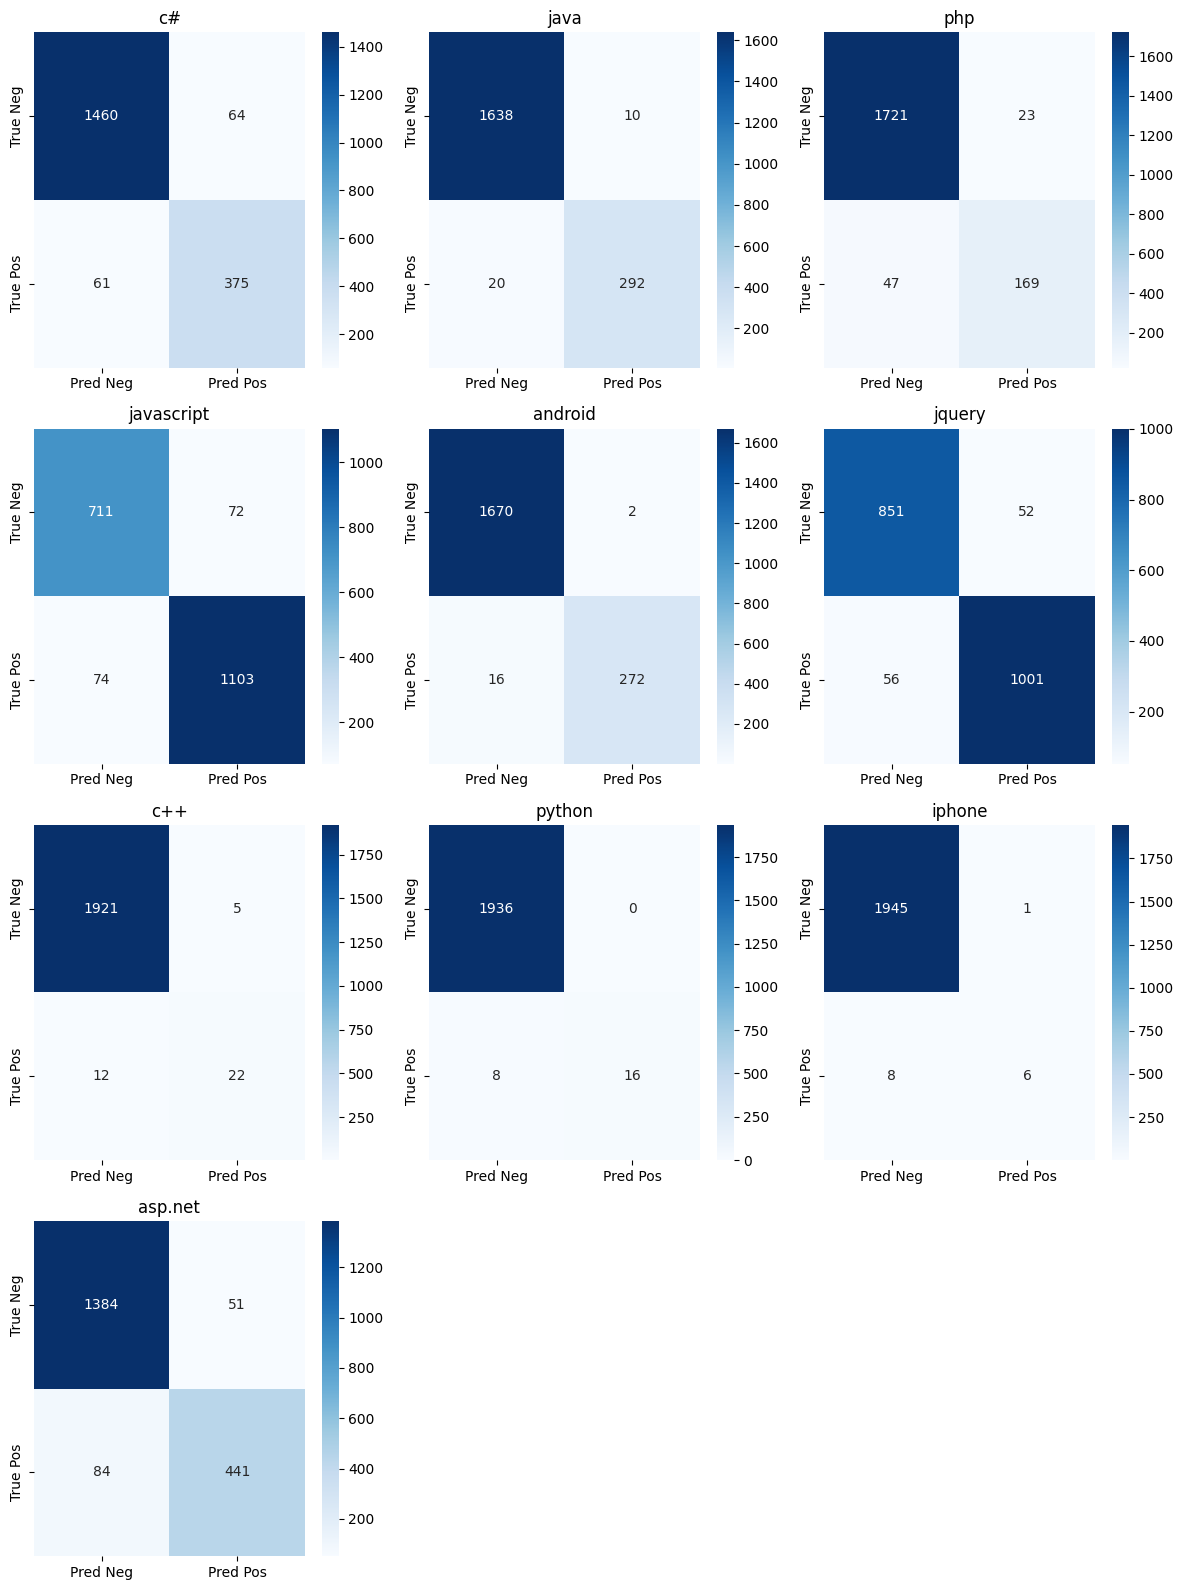

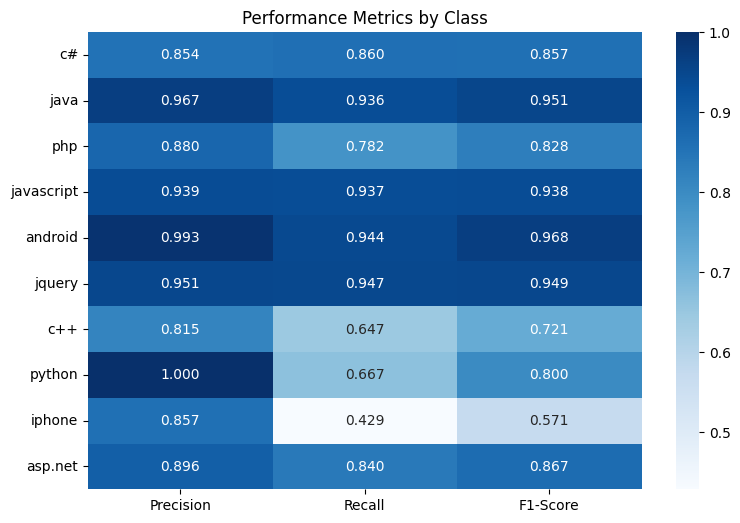

<Figure size 1200x533.333 with 0 Axes>

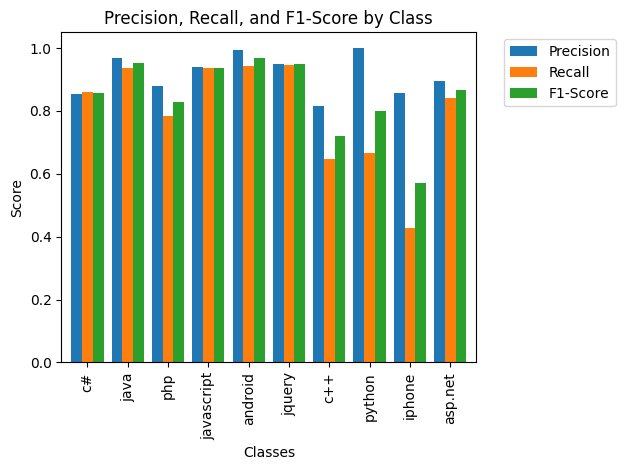

{'macro_avg': {'precision': 0.9151650427063961,
  'recall': 0.7989286109454209,
  'f1': 0.845142284503892},
 'per_class': {'Precision': {'c#': 0.8542141230068337,
   'java': 0.9668874172185431,
   'php': 0.8802083333333334,
   'javascript': 0.9387234042553192,
   'android': 0.9927007299270073,
   'jquery': 0.9506172839506173,
   'c++': 0.8148148148148148,
   'python': 1.0,
   'iphone': 0.8571428571428571,
   'asp.net': 0.8963414634146342},
  'Recall': {'c#': 0.8600917431192661,
   'java': 0.9358974358974359,
   'php': 0.7824074074074074,
   'javascript': 0.9371282922684792,
   'android': 0.9444444444444444,
   'jquery': 0.9470198675496688,
   'c++': 0.6470588235294118,
   'python': 0.6666666666666666,
   'iphone': 0.42857142857142855,
   'asp.net': 0.84},
  'F1-Score': {'c#': 0.8571428571428571,
   'java': 0.9511400651465798,
   'php': 0.8284313725490197,
   'javascript': 0.9379251700680272,
   'android': 0.9679715302491103,
   'jquery': 0.9488151658767773,
   'c++': 0.7213114754098361

In [ ]:
multilabel_evaluation(y_true=valid_labels_binary, y_pred=valid_predictions_binary, class_names=class_names, figsize=(12, 8))

#  <font color = 'indianred'> **7. Performance on Test Set** </font>
For test set evaluation, we will perfrom following steps:



In [ ]:
test_split

Dataset({
    features: ['text', 'label'],
    num_rows: 2000
})

In [ ]:
test_split = test_split.map(format_chat_inference)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
test_filtered = test_split.filter(check_length)

print(f"Train: {len(train_split)} -> {len(test_filtered)}")


Filter:   0%|          | 0/2000 [00:00<?, ? examples/s]

Train: 2000 -> 1957


In [ ]:
test_filtered

Dataset({
    features: ['text', 'label'],
    num_rows: 1957
})

In [ ]:
free_gpu_memory()

GPU memory has been freed.


In [ ]:
test_responses, test_extracted_outputs = run_inference_instruction(
    seed=42,
    dataset=test_filtered,
    model=model,
    tokenizer=tokenizer,
    per_device_batch_size=30,
)

Generating predictions: 100%|██████████| 66/66 [02:44<00:00,  2.49s/it]


In [ ]:
# Clean the labels and predictions
test_labels = [clean_and_split_labels(output['true_output'], class_names) for output in test_extracted_outputs]
test_predictions = [clean_and_split_labels(output['extracted_output'], class_names) for output in test_extracted_outputs]

# Initialize MultiLabelBinarizer with known classes
mlb = MultiLabelBinarizer(classes=class_names)
mlb.fit(class_names)  # Fit with all possible classes

# Transform the data
test_labels_binary = mlb.transform(test_labels)
test_predictions_binary = mlb.transform(test_predictions)

In [ ]:
test_results = compute_metrics(test_labels_binary , test_predictions_binary)

In [ ]:
test_results

{'f1_micro': 0.9127566894835096,
 'f1_macro': 0.807950717397992,
 'accuracy_label': 0.9641798671435872,
 'accuracy_all': 0.8140010219724068}

In [ ]:
wandb.log({"test_f1_macro": test_results["f1_macro"]})

<font color = 'indianred'> *Confusion Matrix*</font>

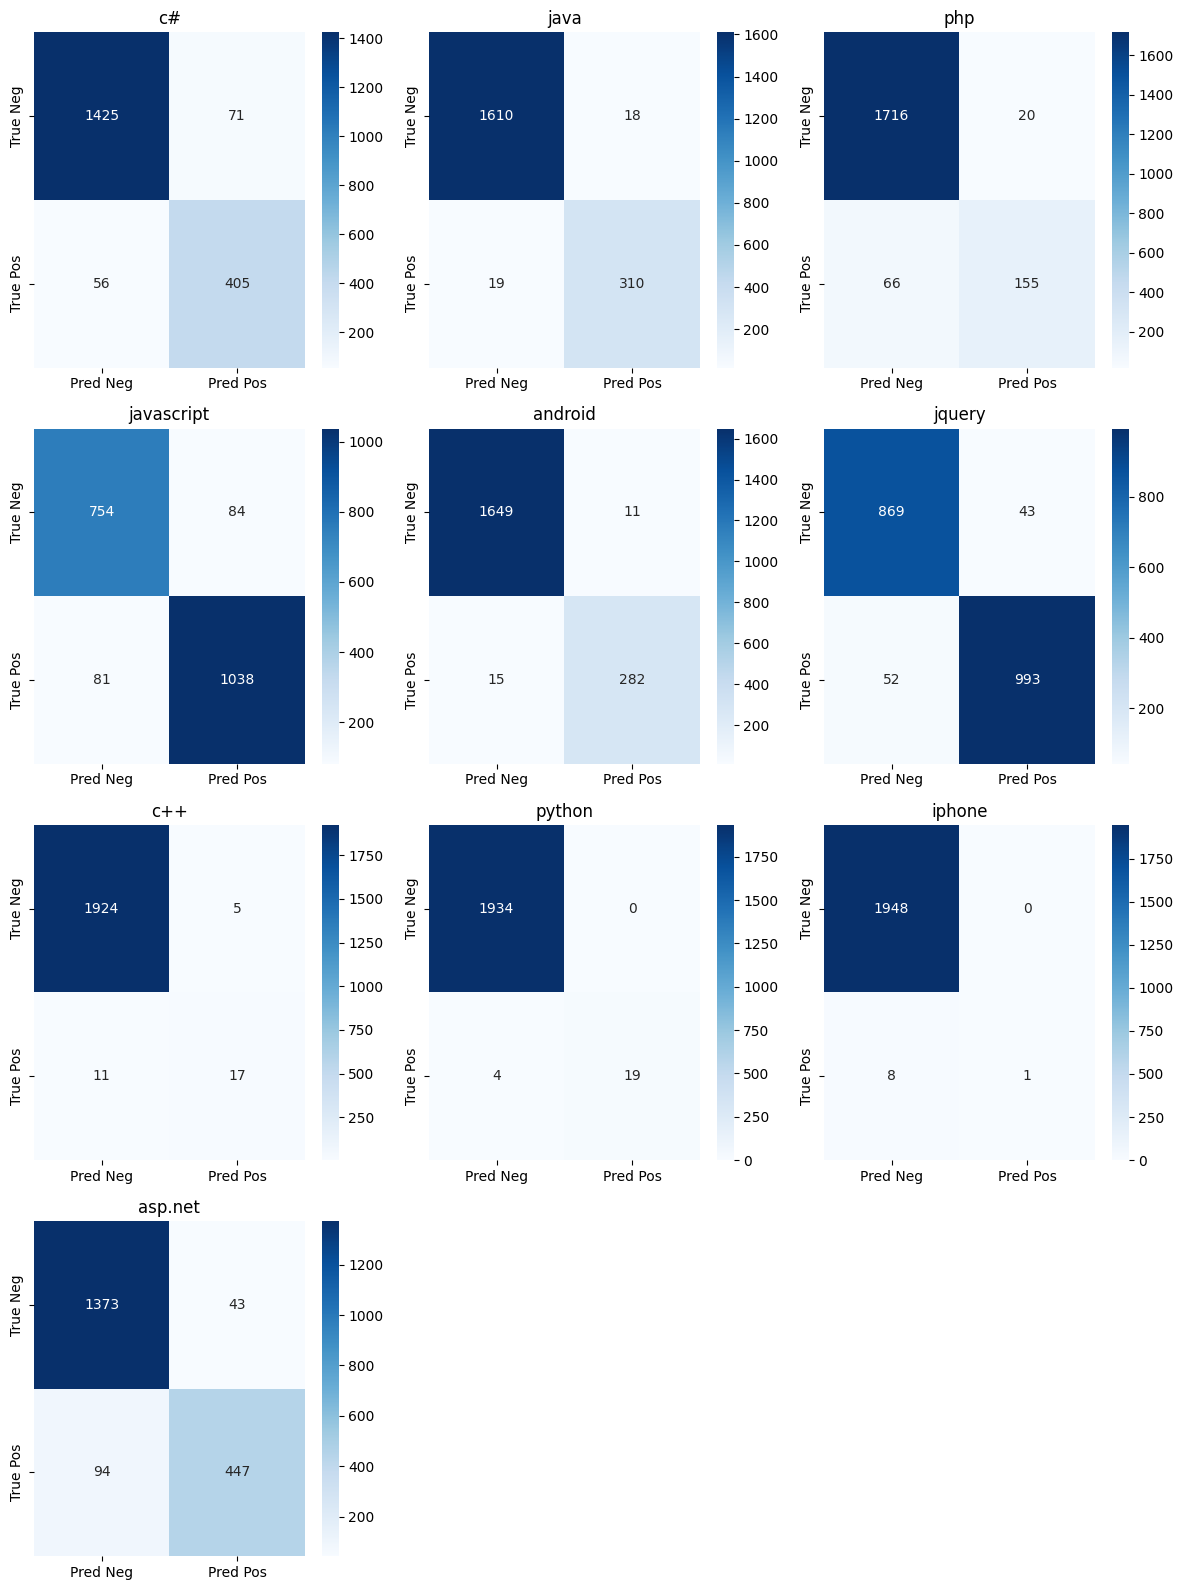

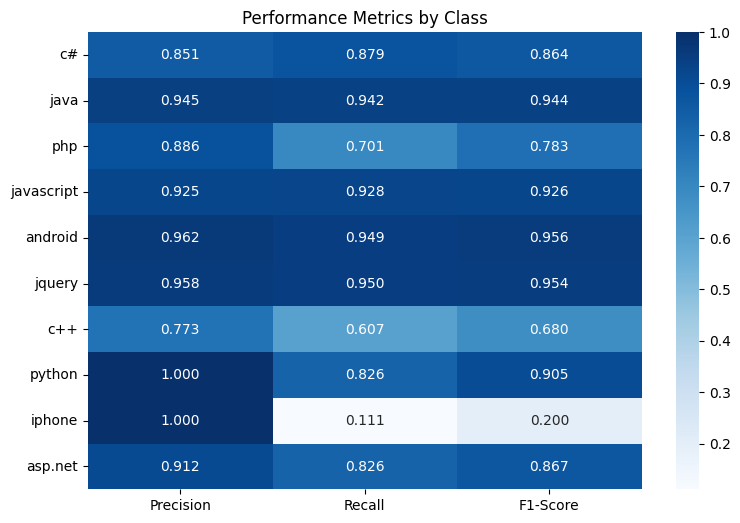

<Figure size 1200x533.333 with 0 Axes>

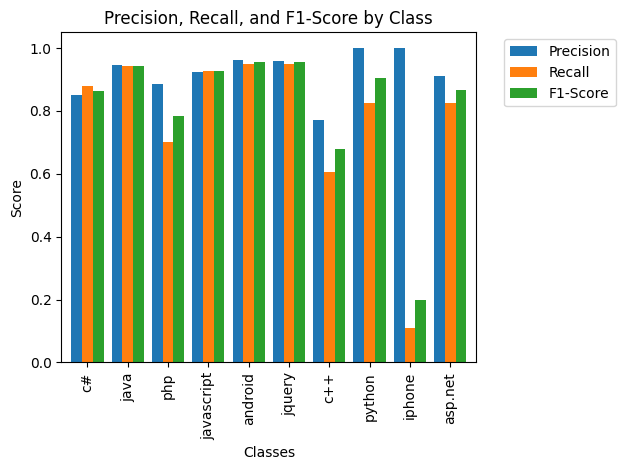

{'macro_avg': {'precision': 0.9212733979972448,
  'recall': 0.7720068391158134,
  'f1': 0.807950717397992},
 'per_class': {'Precision': {'c#': 0.8508403361344538,
   'java': 0.9451219512195121,
   'php': 0.8857142857142857,
   'javascript': 0.9251336898395722,
   'android': 0.962457337883959,
   'jquery': 0.9584942084942085,
   'c++': 0.7727272727272727,
   'python': 1.0,
   'iphone': 1.0,
   'asp.net': 0.9122448979591836},
  'Recall': {'c#': 0.8785249457700651,
   'java': 0.9422492401215805,
   'php': 0.7013574660633484,
   'javascript': 0.9276139410187667,
   'android': 0.9494949494949495,
   'jquery': 0.9502392344497608,
   'c++': 0.6071428571428571,
   'python': 0.8260869565217391,
   'iphone': 0.1111111111111111,
   'asp.net': 0.8262476894639557},
  'F1-Score': {'c#': 0.8644610458911419,
   'java': 0.943683409436834,
   'php': 0.7828282828282829,
   'javascript': 0.9263721552878179,
   'android': 0.9559322033898305,
   'jquery': 0.9543488707352235,
   'c++': 0.68,
   'python': 0.9

In [ ]:
multilabel_evaluation(y_true=test_labels_binary, y_pred=test_predictions_binary, class_names=class_names, figsize=(12, 8))

In [ ]:
wandb.finish()

eval/loss,█▄▂▂▂▁
eval/runtime,▁█▆█▆▆
eval/samples_per_second,█▁▃▁▃▃
eval/steps_per_second,█▁▃▁▃▃
test_f1_macro,▁
train/epoch,▁▁▂▂▄▄▅▅▆▆███
train/global_step,▁▁▂▂▄▄▅▅▆▆███████
train/grad_norm,█▅▅▁▃▂
train/learning_rate,█▇▅▄▂▁
train/loss,█▂▁▁▁▁
valid_f1_macro,█▁▇


# <Font color = 'indianred'> **8. Model Inference**



In [ ]:
model_folder = base_folder/'models/gemma_qlora_lmh_inst'
checkpoint = str(model_folder/f'checkpoint-{best_model_checkpoint_step}')
model = AutoPeftModelForCausalLM.from_pretrained(checkpoint,
                                             quantization_config=bnb_config,
                                             torch_dtype=torch_data_type,
                                             trust_remote_code=True,
                                             device_map='auto')
peft_config = PeftConfig.from_pretrained(checkpoint)
base_model_name = peft_config.base_model_name_or_path
tokenizer = AutoTokenizer.from_pretrained(base_model_name)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
_, extracted_outputs= run_inference_instruction(
    seed=42,
    dataset=test_filtered.select(range(10)),
    model=model,
    tokenizer=tokenizer,
    per_device_batch_size=30,
)

Generating predictions: 100%|██████████| 1/1 [00:01<00:00,  1.63s/it]


In [ ]:
test_predictions = [clean_and_split_labels(output['extracted_output'], class_names) for output in extracted_outputs]

In [ ]:
test_predictions

[['java', 'android'],
 ['java', 'android'],
 ['php', 'javascript'],
 ['c#', 'asp.net'],
 ['javascript', 'asp.net'],
 ['javascript', 'jquery'],
 ['javascript', 'jquery'],
 ['java', 'android'],
 ['php', 'javascript'],
 ['c#', 'asp.net']]